# Best and worst molecules analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from scipy import stats
from torch.nn.utils.rnn import pad_sequence
from sklearn.neural_network import MLPRegressor
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.metrics import mean_squared_error, r2_score
import time

## Getting the data ready

In [2]:
data_train = pd.read_csv('../../data/3_final_data/split_data/logP_wo_parameters_train.csv', index_col=0)
data_valid = pd.read_csv('../../data/3_final_data/split_data/logP_wo_parameters_validation.csv', index_col=0)
data_test = pd.read_csv('../../data/3_final_data/split_data/logP_wo_parameters_test.csv', index_col=0)

In [3]:
y_train = data_train.logP
y_valid = data_valid.logP
y_test = data_test.logP

In [4]:
X_train_mol = [Chem.MolFromSmiles(x) for x in data_train.smiles]
X_valid_mol = [Chem.MolFromSmiles(x) for x in data_valid.smiles]
X_test_mol = [Chem.MolFromSmiles(x) for x in data_test.smiles]

## Building the model

In [5]:
def get_morgan_count_fps(data, bits=2048, radius=2):
    X = [AllChem.GetHashedMorganFingerprint(m, radius, nBits=bits) for m in data]
    X_list = []
    for x in X:
        array = np.zeros((0,), dtype=np.int64)
        DataStructs.ConvertToNumpyArray(x, array)
        X_list.append(array)
    X = pd.DataFrame(X_list)
    return X

In [6]:
start_time = time.time()

X_train = get_morgan_count_fps(X_train_mol)
X_valid = get_morgan_count_fps(X_valid_mol)

regr = MLPRegressor(random_state=10, max_iter=1, warm_start=True)

valid_rmse = 10 ** 3
epoch_count = 1
valid_rmses = []
train_rmses = []
valid_r2s = []
train_r2s = []

y_predicted = regr.fit(X_train, y_train).predict(X_valid)
rmse = mean_squared_error(y_valid, y_predicted, squared = False)
while rmse < valid_rmse:
    valid_rmse = rmse
    train_rmse = mean_squared_error(y_train, regr.predict(X_train), squared = False)
    valid_rmses.append(valid_rmse)
    train_rmses.append(train_rmse)
    
    valid_r2 = r2_score(y_valid, y_predicted)
    valid_r2s.append(valid_r2)
    
    train_r2 = r2_score(y_train, regr.predict(X_train))
    train_r2s.append(train_r2)
    
    epoch_count += 1
    regr.fit(X_train, y_train)
    y_predicted = regr.predict(X_valid)
    rmse = mean_squared_error(y_valid, y_predicted, squared = False)

valid_rmses.append(rmse)
train_rmses.append(mean_squared_error(y_train, regr.predict(X_train), squared = False))

valid_r2s.append(r2_score(y_valid, y_predicted))
train_r2s.append(r2_score(y_train, regr.predict(X_train)))
    
seconds = time.time() - start_time
print("Fitting with params radius=2, bits=2048 finished. RMSE={0} was achieved after {1} epochs in {2:.2f} seconds\n".
      format(rmse, epoch_count, seconds))

C:\Users\lizzka239\anaconda3\envs\chemvae\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fitting with params radius=2, bits=2048 finished. RMSE=0.5158616648362919 was achieved after 9 epochs in 65.43 seconds



In [7]:
rmses = pd.DataFrame({'train_rmses':train_rmses, 'valid_rmses' : valid_rmses})

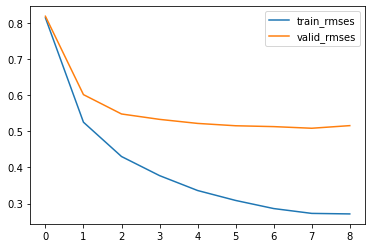

In [8]:
rmses.plot()

In [9]:
r2s = pd.DataFrame({'train_r2':train_r2s, 'valid_r2' : valid_r2s})

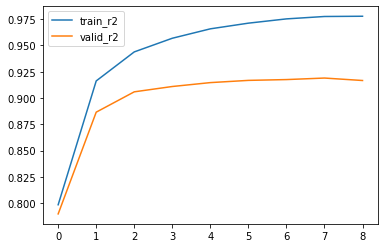

In [10]:
r2s.plot()

In [11]:
X_train = get_morgan_count_fps(X_train_mol)
X_valid = get_morgan_count_fps(X_valid_mol)
X_test = get_morgan_count_fps(X_test_mol)

In [12]:
y_predicted = regr.predict(X_train)
print("Train RMSE =", mean_squared_error(y_train, y_predicted, squared=False))
print("Train R2-score is {0}".format(r2_score(y_train, y_predicted)))

y_predicted = regr.predict(X_valid)
print("Valid RMSE =", mean_squared_error(y_valid, y_predicted, squared=False))
print("Valid R2-score is {0}".format(r2_score(y_valid, y_predicted)))

y_predicted = regr.predict(X_test)
print("Test RMSE =", mean_squared_error(y_test, y_predicted, squared=False))
print("Test R2-score is {0}".format(r2_score(y_test, y_predicted)))

Train RMSE = 0.2713232006398258
Train R2-score is 0.977643180521145
Valid RMSE = 0.5158616648362919
Valid R2-score is 0.9165969192911441
Test RMSE = 0.6308101257309282
Test R2-score is 0.8790616538938645


In [13]:
regr.coefs_[1].shape

(100, 1)

## Getting the data to compare

In [14]:
compare_data = pd.DataFrame({'smiles': data_test.smiles, 'y_expected': y_test, 'y_predicted': y_predicted})

In [15]:
compare_data.head()

,smiles,y_expected,y_predicted
0,Cc1ccccc1C(C)C,4.38,3.701840
1,Clc1nc(-c2ccccc2)nc2ccccc12,4.47,3.943092
2,Cc1ccc(O)c(C(=O)O)c1,2.78,2.143572
3,O=c1[nH]c(O)c(-c2ccccc2)[nH]1,0.46,0.486449
4,CN(C)CCN1c2ccccc2Sc2ccccc21,4.20,3.782067


In [16]:
compare_data.shape

(1894, 3)

In [17]:
compare_data['error'] = (compare_data.y_expected - compare_data.y_predicted) ** 2

In [18]:
compare_data.sort_values(by=['error'], ascending=False).head()

,smiles,y_expected,y_predicted,error
147,CC(C)(C)c1cc(CCC(=O)OCC(COC(=O)CCc2cc(C(C)(C)C...,1.36,16.746316,236.738707
1642,Brc1cc(Br)c(Br)c(-c2c(Br)c(Br)cc(Br)c2Br)c1Br,5.50,10.674148,26.771808
1015,CCc1c(C(=O)O)c(=O)cnn1-c1ccc(Cl)cc1,-2.20,2.731646,24.321130
79,O=C(Cc1ccccc1Nc1c(Cl)cccc1Cl)O[K],0.65,4.304661,13.356546
1278,CC1COCc2cc3c(cc21)C(C)(C)C(C)C3(C)C,5.90,3.780133,4.493835


In [19]:
compare_data.sort_values(by=['error'], ascending=True).head()

,smiles,y_expected,y_predicted,error
1326,O=C(O)CCC1=NS(=O)(=O)c2cc(Cl)c(Cl)cc2N1,1.50,1.499869,1.704221e-08
535,CSc1cc(C(C)C(=O)O)ccc1-c1nccs1,3.02,3.019501,2.489846e-07
1418,O=C(CN1CCCC1)NCc1ccccc1,1.69,1.690665,4.424761e-07
636,CN(C)CCCN1c2ccccc2CCc2ccccc21,4.80,4.800717,5.142617e-07
1167,CCOC(=O)CON=Cc1ccc(OCCOC(=O)c2cc(OC)c(OC)c(OC)...,3.26,3.258364,2.676703e-06


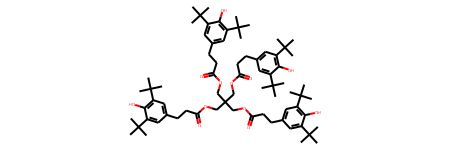

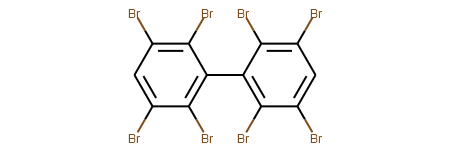

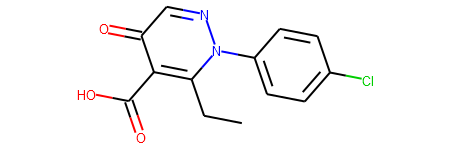

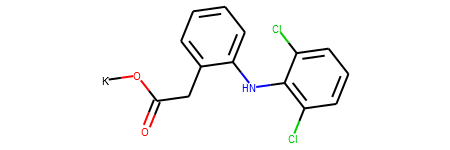

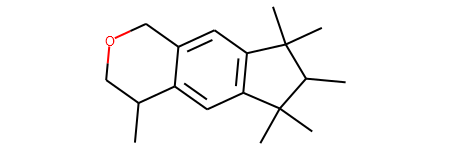

In [20]:
for mol in compare_data.sort_values(by=['error'], ascending=False).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

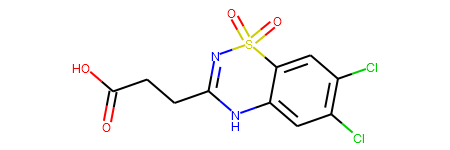

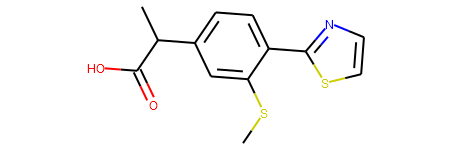

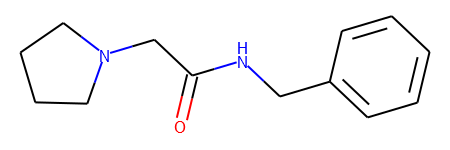

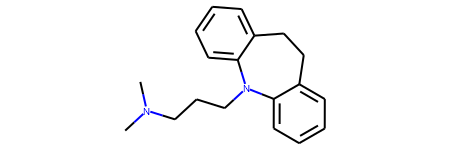

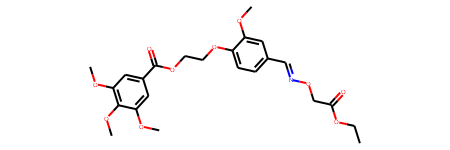

In [21]:
for mol in compare_data.sort_values(by=['error'], ascending=True).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

In [22]:
compare_data = compare_data.sort_values(by=['error'])

## Creating comparing function
### The features to compare:
- The count of atoms
- The count of rings
- The count of not organogens atoms
- The percent of not organogens atoms
- The percent of aromatic (benzene) rings out of all rings

In [27]:
def create_statistics(vals):
    values = vals.copy()
    mols = [Chem.MolFromSmiles(x) for x in values.smiles]
    
    atom_count = [mol.GetNumAtoms() for mol in mols]
    values['atom_count'] = pd.Series(atom_count)
    
    values['ring_count'] = pd.Series([mol.GetRingInfo().NumRings() for mol in mols])
    
    mol_atoms = [mol.GetAtoms() for mol in mols]
    non_simple_atom_count = [sum((num.GetAtomicNum() not in [1, 6, 8, 7]) for num in m_atoms) for m_atoms in mol_atoms]
    values['non_organogens_count'] = pd.Series(non_simple_atom_count)
    
    values['non_organogens_percent'] = values.non_organogens_count / values.atom_count *100
    
    benzene_smiles = 'C1=CC=CC=C1'
    pattern = Chem.MolFromSmiles(benzene_smiles)
    values['aromatic_count'] = pd.Series([len(mol.GetSubstructMatches(pattern)) for mol in mols])
    
    values['aromatic_rings_percent'] = values.aromatic_count / values.ring_count *100
    values['aromatic_rings_percent'] = values['aromatic_rings_percent'].fillna(0)
    
    values['bond_count'] =  [len(mol.GetBonds()) for mol in mols]
    values['aromatic_bond_count'] = [sum(bond.GetIsAromatic() for bond in mol.GetBonds()) for mol in mols]
    values['aromatic_bond_percent'] = values.aromatic_bond_count / values.bond_count * 100
    
    
    return values

## Analyzing the data features

In [28]:
compare_data_with_stats = create_statistics(compare_data)

In [29]:
compare_data_with_stats.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
1326,O=C(O)CCC1=NS(=O)(=O)c2cc(Cl)c(Cl)cc2N1,1.50,1.499869,1.704221e-08,17,3,4,23.529412,2,66.666667,20,6,30.000000
535,CSc1cc(C(C)C(=O)O)ccc1-c1nccs1,3.02,3.019501,2.489846e-07,19,2,0,0.000000,1,50.000000,19,11,57.894737
1418,O=C(CN1CCCC1)NCc1ccccc1,1.69,1.690665,4.424761e-07,26,3,0,0.000000,3,100.000000,17,6,35.294118
636,CN(C)CCCN1c2ccccc2CCc2ccccc21,4.80,4.800717,5.142617e-07,9,1,3,33.333333,0,0.000000,23,12,52.173913
1167,CCOC(=O)CON=Cc1ccc(OCCOC(=O)c2cc(OC)c(OC)c(OC)...,3.26,3.258364,2.676703e-06,14,1,0,0.000000,1,100.000000,36,12,33.333333


#### Splitting data into 3 parts

In [30]:
data = []
for i in range(3):
    data.append(compare_data_with_stats.take([j for j in range(i * 1894 // 3, min((i + 1) * 1894 // 3, 1894))]))

In [31]:
data[0].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,631.000000,631.000000,6.310000e+02,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,1.963603,1.961057,8.887107e-03,16.036450,1.624406,0.839937,5.662833,0.852615,50.892763,16.426307,7.057052,43.864823
std,1.721008,1.717799,7.996011e-03,6.534665,1.098328,1.315858,9.433772,0.819691,43.035246,6.943573,4.228014,23.798254
min,-3.890000,-3.814880,1.704221e-08,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.810000,0.817847,1.577166e-03,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000,11.000000,6.000000,31.250000
50%,1.760000,1.806892,7.070835e-03,15.000000,1.000000,0.000000,0.000000,1.000000,50.000000,16.000000,6.000000,46.153846
75%,2.880000,2.850828,1.455275e-02,19.000000,2.000000,1.000000,8.333333,1.000000,100.000000,20.000000,10.500000,60.000000
max,8.200000,8.096909,2.772389e-02,59.000000,6.000000,9.000000,71.428571,6.000000,100.000000,59.000000,24.000000,100.000000


In [32]:
data[1].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,2.003051,1.985731,0.079366,16.618067,1.671949,0.935024,6.102531,0.898574,53.800845,16.686212,7.150555,43.859894
std,1.750421,1.747430,0.037672,7.225940,1.033636,1.366455,9.350258,0.755413,42.852200,7.090556,4.257710,23.312164
min,-2.510000,-2.799575,0.027775,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.760000,0.782601,0.046723,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,6.000000,31.578947
50%,1.820000,1.859517,0.072473,16.000000,2.000000,0.000000,0.000000,1.000000,50.000000,16.000000,6.000000,45.454545
75%,3.035000,2.925796,0.107887,20.000000,2.000000,1.000000,9.523810,1.000000,100.000000,20.000000,11.000000,60.000000
max,8.200000,8.019364,0.159772,85.000000,8.000000,9.000000,80.000000,4.000000,100.000000,58.000000,26.000000,100.000000


In [33]:
data[2].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000
mean,2.145993,2.073250,1.104391,16.780063,1.738924,0.843354,5.293813,0.867089,52.667458,18.338608,7.460443,41.759248
std,1.959932,1.920826,9.524874,7.301133,1.155105,1.341459,8.335457,0.734950,42.273259,9.085571,5.013928,26.044210
min,-3.700000,-4.062987,0.160289,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.817500,0.845134,0.247621,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,5.000000,27.272727
50%,2.030000,1.965320,0.399566,16.000000,2.000000,0.000000,0.000000,1.000000,50.000000,17.000000,6.000000,42.857143
75%,3.420000,3.107404,0.751412,20.000000,2.000000,1.000000,7.692308,1.000000,100.000000,22.000000,12.000000,60.000000
max,9.050000,16.746316,236.738707,58.000000,8.000000,9.000000,50.000000,4.000000,100.000000,88.000000,27.000000,100.000000


## Check repeting patterns in the middle of the dataset
Hypothesis: badly predicted molecules are symmetric (like 1, 3, 5 worst molecules)

The simplest way to check: take 20 random molecules from the best/middle/worst part.

In [34]:
best = data[0].reset_index().drop(columns=['index'])

In [35]:
best.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
0,O=C(O)CCC1=NS(=O)(=O)c2cc(Cl)c(Cl)cc2N1,1.50,1.499869,1.704221e-08,17,3,4,23.529412,2,66.666667,20,6,30.000000
1,CSc1cc(C(C)C(=O)O)ccc1-c1nccs1,3.02,3.019501,2.489846e-07,19,2,0,0.000000,1,50.000000,19,11,57.894737
2,O=C(CN1CCCC1)NCc1ccccc1,1.69,1.690665,4.424761e-07,26,3,0,0.000000,3,100.000000,17,6,35.294118
3,CN(C)CCCN1c2ccccc2CCc2ccccc21,4.80,4.800717,5.142617e-07,9,1,3,33.333333,0,0.000000,23,12,52.173913
4,CCOC(=O)CON=Cc1ccc(OCCOC(=O)c2cc(OC)c(OC)c(OC)...,3.26,3.258364,2.676703e-06,14,1,0,0.000000,1,100.000000,36,12,33.333333


In [36]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=20))

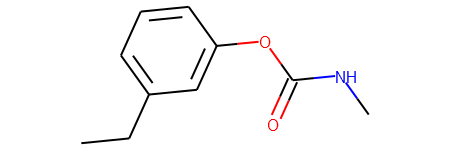

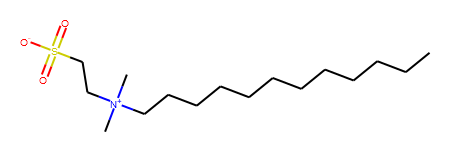

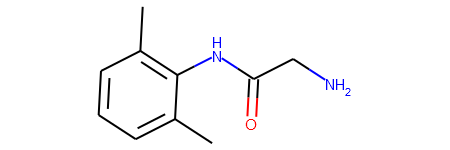

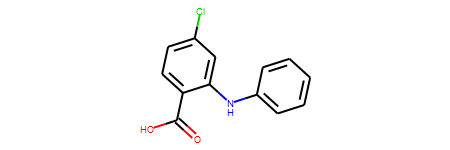

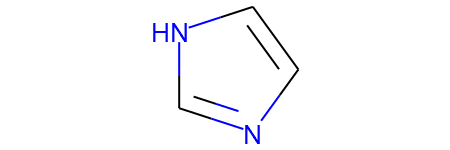

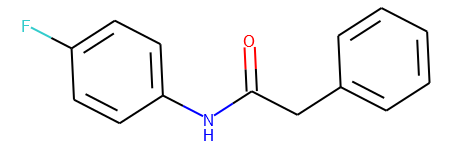

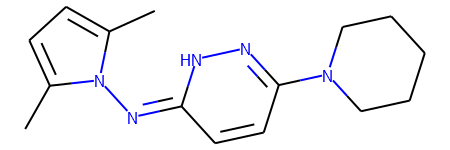

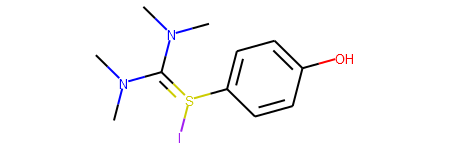

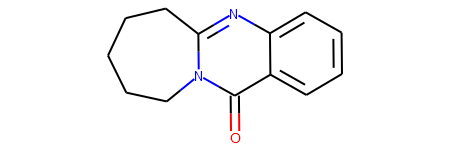

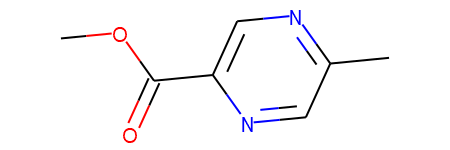

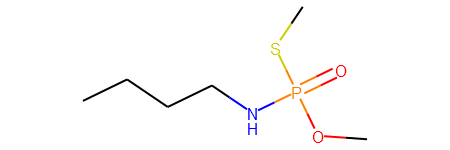

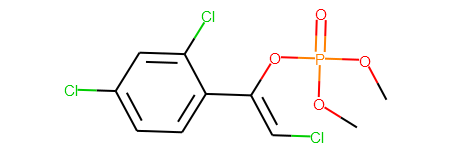

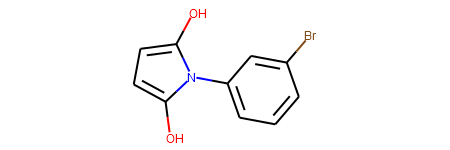

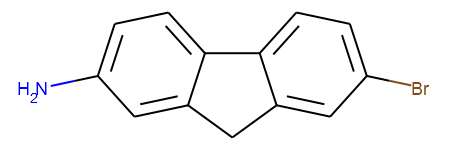

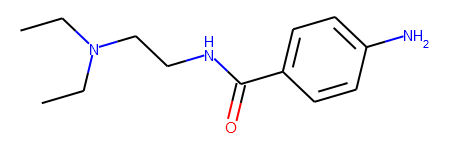

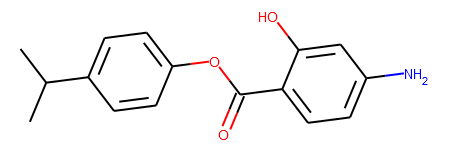

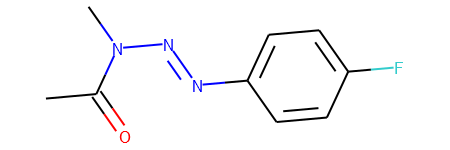

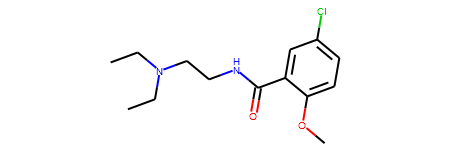

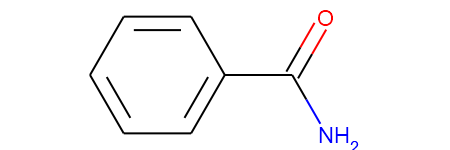

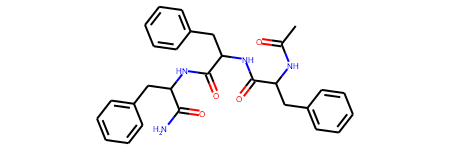

In [37]:
for smiles in best.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [38]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=20))

In [39]:
middle = data[1].reset_index().drop(columns=['index'])

In [40]:
middle.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
0,CC(=O)C=Cc1ccc(OC(C)=O)cc1,1.63,1.796659,0.027775,15,2,0,0.000000,1,50.0,15,6,40.000000
1,CCOc1ncccn1,0.74,0.572685,0.027994,24,2,1,4.166667,2,100.0,9,6,66.666667
2,N=c1[nH][n+]([O-])c2ccc(Cl)cc2[n+]1[O-],0.41,0.577830,0.028167,22,2,1,4.545455,2,100.0,15,11,73.333333
3,COc1cc(Cl)c(Cl)c(Cl)c1,4.22,4.387999,0.028224,11,1,0,0.000000,1,100.0,11,6,54.545455
4,O=C(O)c1ccc([N+](=O)[O-])c(O)c1,1.98,1.810866,0.028606,17,1,2,11.764706,1,100.0,13,6,46.153846


In [41]:
middle.shape

(631, 13)

In [42]:
indices = pd.Series(np.random.randint(631, size=20))

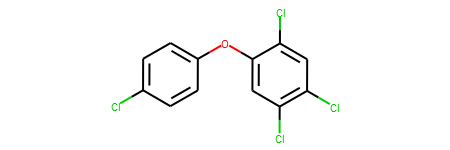

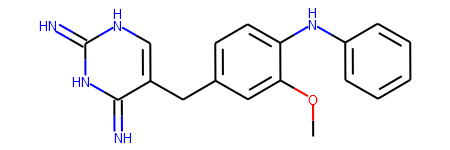

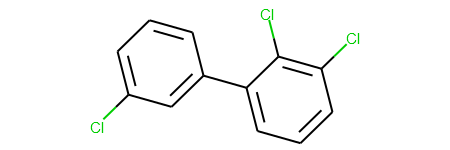

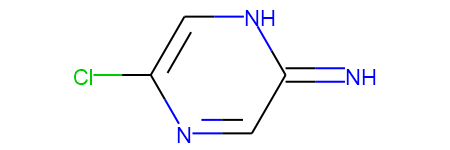

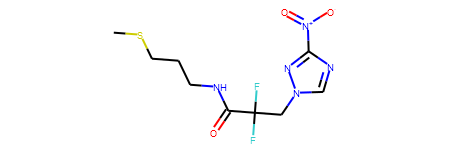

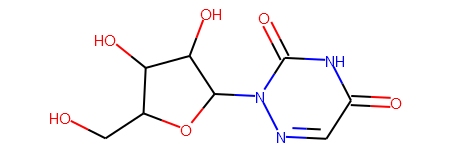

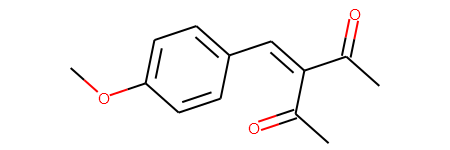

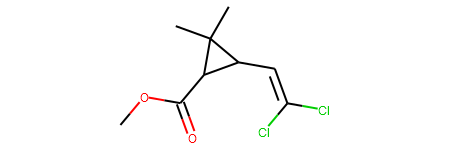

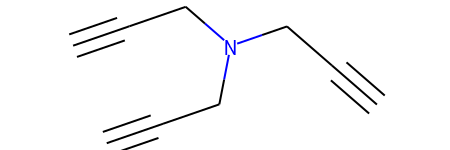

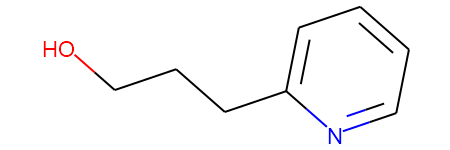

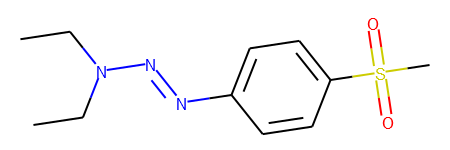

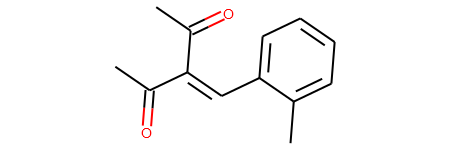

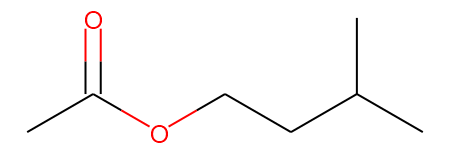

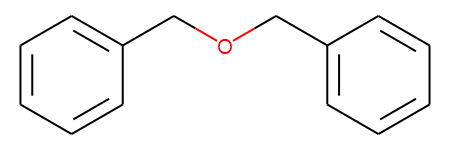

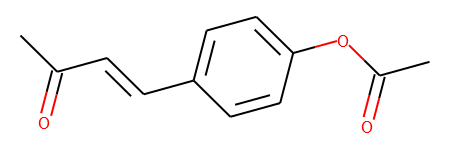

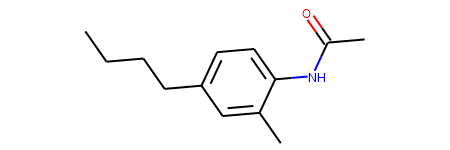

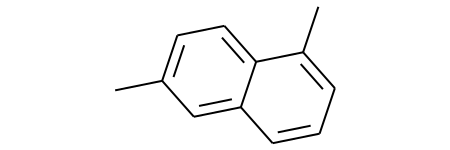

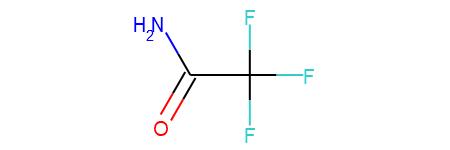

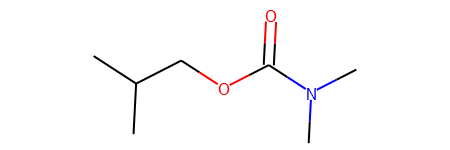

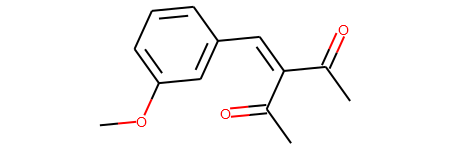

In [43]:
for smiles in middle.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [44]:
worst = data[2].reset_index().drop(columns=['index'])

In [45]:
indices = pd.Series(np.random.randint(631, size=20))

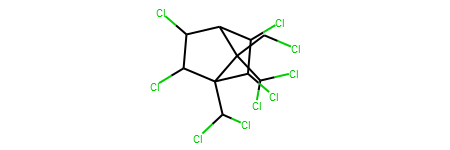

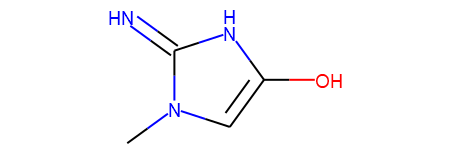

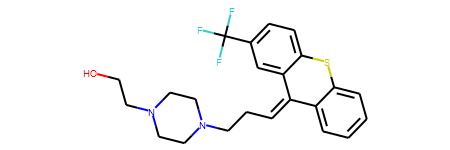

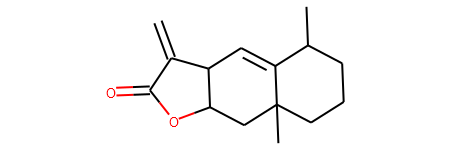

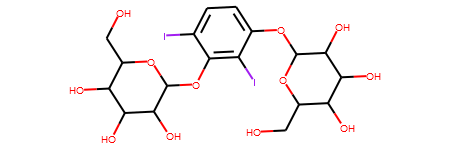

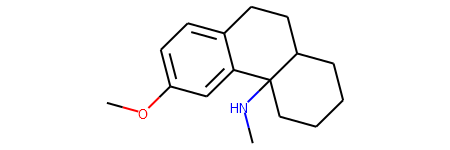

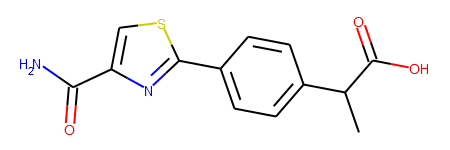

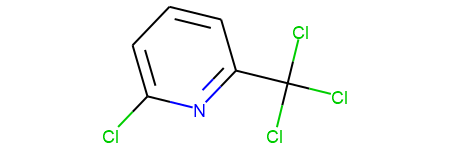

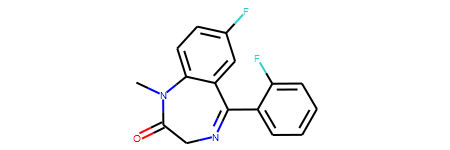

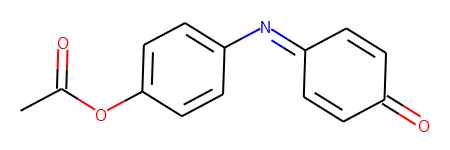

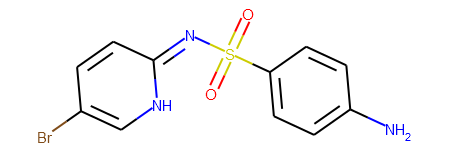

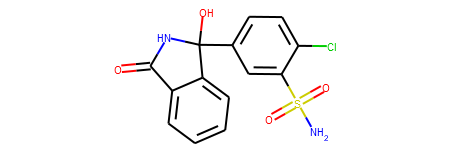

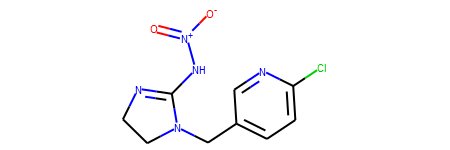

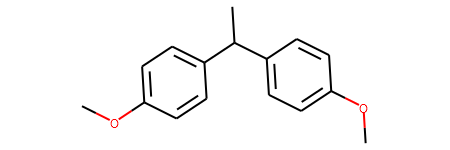

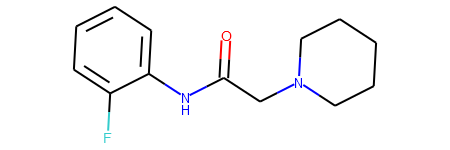

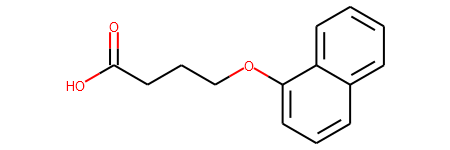

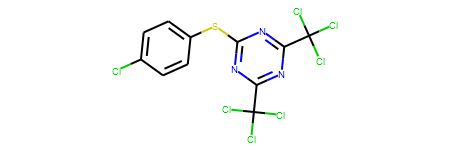

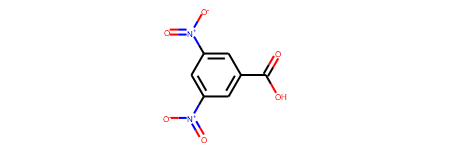

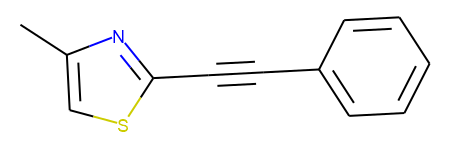

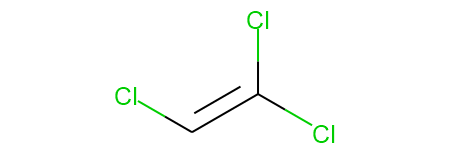

In [46]:
for smiles in worst.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

#### Taking best and worst predicted values

In [47]:
n_values = 50

In [48]:
best_n_vals = compare_data_with_stats.take([j for j in range(n_values)])

In [49]:
worst_n_vals = compare_data_with_stats.take([j for j in range( len(compare_data.smiles) - 1, len(compare_data.smiles) - 1 - n_values, -1)])

In [50]:
best_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
1326,O=C(O)CCC1=NS(=O)(=O)c2cc(Cl)c(Cl)cc2N1,1.50,1.499869,1.704221e-08,17,3,4,23.529412,2,66.666667,20,6,30.000000
535,CSc1cc(C(C)C(=O)O)ccc1-c1nccs1,3.02,3.019501,2.489846e-07,19,2,0,0.000000,1,50.000000,19,11,57.894737
1418,O=C(CN1CCCC1)NCc1ccccc1,1.69,1.690665,4.424761e-07,26,3,0,0.000000,3,100.000000,17,6,35.294118
636,CN(C)CCCN1c2ccccc2CCc2ccccc21,4.80,4.800717,5.142617e-07,9,1,3,33.333333,0,0.000000,23,12,52.173913
1167,CCOC(=O)CON=Cc1ccc(OCCOC(=O)c2cc(OC)c(OC)c(OC)...,3.26,3.258364,2.676703e-06,14,1,0,0.000000,1,100.000000,36,12,33.333333


In [51]:
worst_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
147,CC(C)(C)c1cc(CCC(=O)OCC(COC(=O)CCc2cc(C(C)(C)C...,1.36,16.746316,236.738707,14,1,2,14.285714,0,0.000000,88,24,27.272727
1642,Brc1cc(Br)c(Br)c(-c2c(Br)c(Br)cc(Br)c2Br)c1Br,5.50,10.674148,26.771808,13,2,0,0.000000,1,50.000000,21,12,57.142857
1015,CCc1c(C(=O)O)c(=O)cnn1-c1ccc(Cl)cc1,-2.20,2.731646,24.321130,21,3,1,4.761905,2,66.666667,20,12,60.000000
79,O=C(Cc1ccccc1Nc1c(Cl)cccc1Cl)O[K],0.65,4.304661,13.356546,12,1,0,0.000000,1,100.000000,21,12,57.142857
1278,CC1COCc2cc3c(cc21)C(C)(C)C(C)C3(C)C,5.90,3.780133,4.493835,13,1,3,23.076923,1,100.000000,21,6,28.571429


In [52]:
best_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,50.00000,50.000000,5.000000e+01,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,1.81030,1.809830,5.895287e-05,15.020000,1.540000,0.820000,5.910265,0.800000,53.000000,15.420000,6.940000,42.101212
std,1.62426,1.625358,4.698978e-05,5.430413,0.930438,1.272792,9.957797,0.699854,43.211498,6.639677,4.559851,22.984013
min,-0.83000,-0.832777,1.704221e-08,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000
25%,0.57250,0.564948,1.224553e-05,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000,11.000000,6.000000,33.333333
50%,1.58500,1.574199,5.657607e-05,14.000000,1.000000,0.000000,0.000000,1.000000,50.000000,15.000000,6.000000,46.153846
75%,2.68875,2.695670,1.049067e-04,18.000000,2.000000,1.000000,9.090909,1.000000,100.000000,18.000000,10.750000,55.944056
max,7.10000,7.110928,1.471487e-04,32.000000,4.000000,6.000000,50.000000,3.000000,100.000000,39.000000,22.000000,91.666667


In [53]:
worst_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,1.849300,2.297710,8.221707,17.980000,1.780000,0.780000,5.151336,0.880000,46.666667,20.120000,6.620000,35.817867
std,2.211621,3.039370,33.328646,8.365356,1.183043,1.183043,8.625624,0.824126,40.230346,12.390978,5.114565,25.077761
min,-3.170000,-1.717290,1.679721,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000
25%,0.432500,0.486929,2.036501,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,14.250000,1.250000,6.000000
50%,2.042500,1.751672,2.414752,17.000000,2.000000,0.000000,0.000000,1.000000,50.000000,18.000000,6.000000,40.000000
75%,3.277500,3.402813,2.751188,21.750000,2.000000,1.000000,6.746032,1.000000,100.000000,21.000000,11.000000,57.142857
max,7.000000,16.746316,236.738707,56.000000,5.000000,4.000000,33.333333,4.000000,100.000000,88.000000,24.000000,78.571429


### Check atom_count influence

In [54]:
print(stats.ttest_ind(best_n_vals.atom_count, worst_n_vals.atom_count))

Ttest_indResult(statistic=-2.0986198333196673, pvalue=0.03842145733957249)


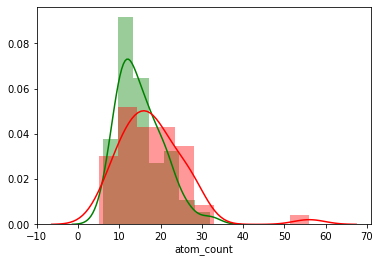

In [55]:
sns.distplot(best_n_vals.atom_count, color='g')
sns.distplot(worst_n_vals.atom_count, color='r')

### Check ring_count influence

In [56]:
print(stats.ttest_ind(best_n_vals.ring_count, worst_n_vals.ring_count))

Ttest_indResult(statistic=-1.1275421727595607, pvalue=0.2622663987535076)


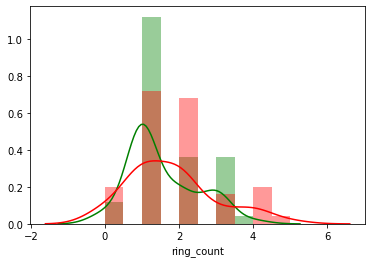

In [57]:
sns.distplot(best_n_vals.ring_count, color='g')
sns.distplot(worst_n_vals.ring_count, color='r')

### Check non_organogens_count influence

In [58]:
print(stats.ttest_ind(best_n_vals.non_organogens_count, worst_n_vals.non_organogens_count))

Ttest_indResult(statistic=0.16276869149686934, pvalue=0.8710357233655956)


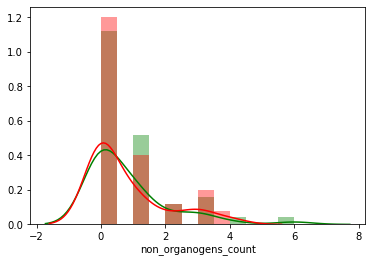

In [59]:
sns.distplot(best_n_vals.non_organogens_count, color='g')
sns.distplot(worst_n_vals.non_organogens_count, color='r')

### Check non_organogens_percent influence

In [60]:
print(stats.ttest_ind(best_n_vals.non_organogens_percent, worst_n_vals.non_organogens_percent))

Ttest_indResult(statistic=0.407345070126882, pvalue=0.6846429804811949)


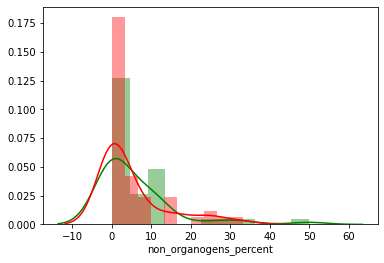

In [61]:
sns.distplot(best_n_vals.non_organogens_percent, color='g')
sns.distplot(worst_n_vals.non_organogens_percent, color='r')

### Check aromatic_count influence

In [62]:
print(stats.ttest_ind(best_n_vals.aromatic_count, worst_n_vals.aromatic_count))

Ttest_indResult(statistic=-0.5232045649263549, pvalue=0.6020129276509051)


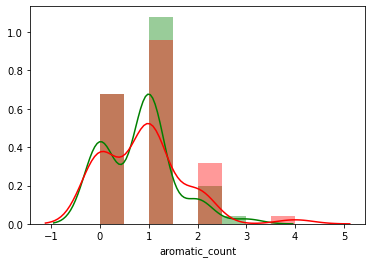

In [63]:
sns.distplot(best_n_vals.aromatic_count, color='g')
sns.distplot(worst_n_vals.aromatic_count, color='r')

### Check aromatic_rings_percent influence

In [64]:
print(stats.ttest_ind(best_n_vals.aromatic_rings_percent, worst_n_vals.aromatic_rings_percent))

Ttest_indResult(statistic=0.7585277178356479, pvalue=0.44995553670999244)


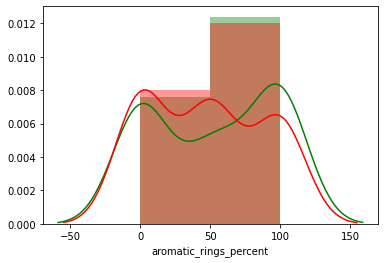

In [65]:
sns.distplot(best_n_vals.aromatic_rings_percent, color='g')
sns.distplot(worst_n_vals.aromatic_rings_percent, color='r')

### Check aromatic bond percent

In [66]:
print(stats.ttest_ind(best_n_vals.aromatic_bond_percent, worst_n_vals.aromatic_bond_percent))

Ttest_indResult(statistic=1.3061088288222482, pvalue=0.1945729232190207)


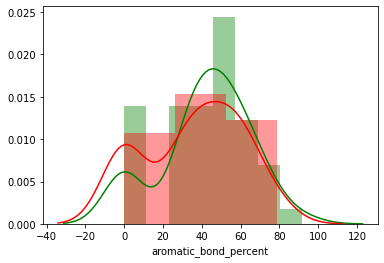

In [67]:
sns.distplot(best_n_vals.aromatic_bond_percent, color='g')
sns.distplot(worst_n_vals.aromatic_bond_percent, color='r')

### Check aromatic bond percent

In [ ]:
print(stats.ttest_ind(best_n_vals.aromatic_bond_count, worst_n_vals.aromatic_bond_count))